# In this approach we try to classify images based on feature detection and feature matching algorithms


ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance. First it use FAST to find keypoints, then apply Harris corner measure to find top N points among them. It also use pyramid to produce multiscale-features.

It computes the intensity weighted centroid of the patch with located corner at center. The direction of the vector from this corner point to centroid gives the orientation. To improve the rotation invariance, moments are computed with x and y which should be in a circular region of radius r, where r is the size of the patch.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.spatial import distance as dist
import imutils
import time

In [42]:
from skimage.util import img_as_float
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure


In [43]:
from pathlib import Path
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
from skimage.transform import resize

In [44]:
from gtts import gTTS 
from playsound import playsound
import os 

def speechtoText(mytext):
    if mytext == "Rs 10":
        playsound("sounds/10.mp3")
    if mytext == "Rs 20":
        playsound("sounds/20.mp3")
    if mytext == "Rs 50":
        playsound("sounds/50.mp3")
    if mytext == "Rs 100":
        playsound("sounds/100.mp3")
    if mytext == "Rs 200":
        playsound("sounds/200.mp3")
    if mytext == "Rs 500":
        playsound("sounds/500.mp3")
    if mytext == "Rs 2000":
        playsound("sounds/2000.mp3")
        
    

In [45]:
def auto_canny(image, sigma=0.33):
    
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    
    # return the edged image
    return edged

In [46]:
def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [47]:
def four_point_transform(image, pts):
    
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
  
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    # return the warped image
    return warped

In [48]:
def preprocess(image):
    #image = cv2.imread('train_image/4/30.jpg')
    ratio = image.shape[0] / 500.0
    orig = image.copy()
    image = imutils.resize(image, height = 500)


    # convert the image to grayscale, blur it, and find edges
    # in the image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    edged = auto_canny(gray)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)

    """plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(edged,cmap='gray')
    print(image.shape)"""
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    # loop over the contours
    flag=0
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            flag=1
            break

        # show the contour (outline) of the piece of paper
    if flag==1:
        print("STEP 2: Find contours of paper")
        im=cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
        
        #plt.imshow(im)
        
        warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

        # show the original and scanned images
        print("STEP 3: Apply perspective transform")
        orig=imutils.resize(orig, height = 650)
        warped=imutils.resize(warped, height = 650)
        #orig=cv2.resize(orig, (500, 500),interpolation = cv2.INTER_NEAREST) 
        #warped=cv2.resize(warped, (500, 500),interpolation = cv2.INTER_NEAREST) 

        """plt.figure(figsize=(12,12))
        plt.subplot(1,2,1)
        plt.imshow(orig)
        plt.subplot(1,2,2)
        plt.imshow(warped)
        print(warped.shape)"""
        
        return warped
    else:
        return orig


In [49]:
def load_all_image_from_path(path):
    images=[] 
    image_dir = Path(path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]
    for i, direc in enumerate(folders):
        image_list = []
        for file in direc.iterdir():
            file = str(file)
            im= cv2.imread(file)
            image_list.append(im)
        images.append(image_list)
    return images

In [50]:
def display_image(image):
    plt.imshow(image)


In [51]:
def combine_image(image1, image2):
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    print("------------------------------------\n\n")

    # create empty matrix
    vis = np.zeros((max(h1, h2), w1 + w2), np.uint8)

    # combine 2 images
    vis[:h1, :w1] = image1
    vis[:h2, w1:w1 + w2] = image2
    return vis

In [52]:
def orb_with_flann(image_query, image_train):
    orb = cv2.ORB_create(nfeatures=3000)

    # find key point and descriptor
    kp_logo, des_logo = orb.detectAndCompute(image_train, None)
    kp_img, des_img = orb.detectAndCompute(image_query, None)

    # view key point
    #result_image_train = cv2.drawKeypoints(image_train, kp_logo, None, flags=0)
    #result_image_query = cv2.drawKeypoints(image_query, kp_img, None, flags=0)
    #display_image(result_image_train,"train")
    #display_image(result_image_query,"query")

    # FLANN parameters
    flann_index_lsh = 6
    index_params = dict(algorithm=flann_index_lsh,
                        table_number=12,
                        key_size=20,
                        multi_probe_level=2)
    search_params = dict(checks=50)  # or pass empty dictionary

    # create FLANN
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # perform matching
    flann_matches = flann.knnMatch(des_logo, des_img, k=2)

    #View match without fillter.
    #img3 = cv2.drawMatchesKnn(image_train, kp_logo, image_query, kp_img, flann_matches, None)
    #display_image(img3)
    #plt.imshow(img3)
    # Need to draw only good matches, so create a mask
    matches_mask = [[0, 0] for i in range(len(flann_matches))]

    # ratio test as per Lowe's paper
    good = []
    for index in range(len(flann_matches)):
        if len(flann_matches[index]) == 2:
            m, n = flann_matches[index]
            if m.distance < 0.8 * n.distance:  # threshold of ratio testing
                matches_mask[index] = [1, 0]
                good.append(flann_matches[index])

    # draw match after filter
    draw_params = dict(
        singlePointColor=(255, 0, 0),
        matchesMask=matches_mask,
        flags=2)

    img3 = cv2.drawMatchesKnn(image_train, kp_logo, image_query, kp_img, flann_matches, None, **draw_params)

    #font = cv2.FONT_HERSHEY_SIMPLEX
     #cv2.putText(img3, str(len(good)), (0, 50), font, 2, (0, 0, 255), 2, cv2.LINE_AA)
    #display_image(img3)  # view matching image
    #plt.imshow(img3)
    
    return image_train, len(good)

In [53]:
def find_best_match_index(match):
    index_best = 0
    best_length = 0
    for index, (image, good_match_length) in enumerate(match):
        if good_match_length >= best_length:
            best_length = good_match_length
            index_best = index
    return index_best


In [54]:
    # load image
def check_image(train_image_list,query_image,totalmatches):
    #for index, query_image in enumerate(query_image_list1):
        matches = []

        # get process time
        start = int(round(time.time() * 1000))
        for train_image in train_image_list:
            matches.append(orb_with_flann(query_image, train_image))
        end = int(round(time.time() * 1000)) - start
        print("process time: " + end.__str__())
        
        # find the best match
        best_match_index = find_best_match_index(matches)
        totalmatches.append(matches[best_match_index][1])
        
        return totalmatches

# LOADING IMAGES FROM ALL THE FOLDERS OF THE DATASET

In [55]:
total_train_image_list = load_all_image_from_path("official dataset/")

A function to classify image on the index of the folder in which it is macthed

In [56]:
len(total_train_image_list)

7

In [57]:
def classify(index):
    if index==0:
        return "Rs 10"
    if index==1:
        return "Rs 20"
    if index==2:
        return "Rs 50"
    if index==3:
        return "Rs 100"
    if index==4:
        return "Rs 200"
    if index==5:
        return "Rs 500"
    if index==6:
        return "Rs 2000"


In [58]:
def detect(im):
    query_image_list=[]
    #plt.figure(figsize=(12,12))
    #plt.imshow(im)
    im= preprocess(im)
    query_image_list.append(im)
    for i in range(len(query_image_list)):
        find_matches=[]
        for j in range(len(total_train_image_list)):    
            find_matches=check_image(total_train_image_list[j],query_image_list[i],find_matches)


        #plt.subplot(len(query_image_list),1,i+1)
        #plt.imshow(query_image_list[i],cmap='gray')
        string=classify(find_matches.index(max(find_matches)))
        #print(string)
        #print("\n")
        #speechtoText(string)
    return string,query_image_list

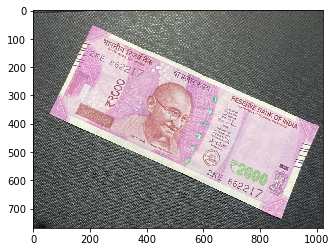

In [115]:
im=cv2.imread("test/6.jpg")
im_rgb=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
display_image(im_rgb)

In [116]:
string, query_image_list = detect(im)
speechtoText(string)
    

STEP 2: Find contours of paper
STEP 3: Apply perspective transform
process time: 308
process time: 284
process time: 332
process time: 395
process time: 172
process time: 174
process time: 167


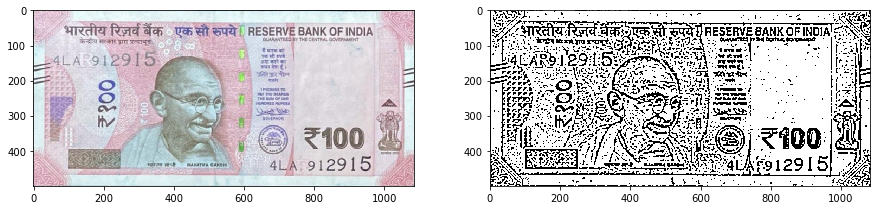

In [37]:
image2=query_image_list[0].copy()
ratio = image2.shape[0] / 500.0
orig = image2.copy()
image2 = imutils.resize(image2, height = 500)

gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)
gray2 = cv2.GaussianBlur(gray2, (9, 9), 0)

"""edged = auto_canny(gray2)
#edged=cv2.Canny(gray2,150,200)
edged = cv2.dilate(edged, None, iterations=2)
edged = cv2.erode(edged, None, iterations=2)"""

#ret, thresh2 = cv2.threshold(gray2, 120, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh2=cv2.adaptiveThreshold(gray2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
thresh2 = cv2.erode(thresh2, None, iterations=1)
thresh2 = cv2.dilate(thresh2, None, iterations=1)


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(image2)
plt.subplot(1,2,2)
#plt.imshow(edged,cmap='gray')
plt.imshow(thresh2,cmap='gray')

In [38]:
cnts = cv2.findContours(thresh2.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse=True)[:]


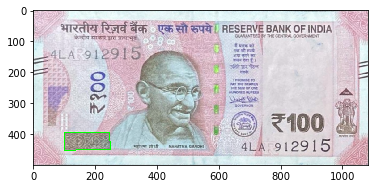

In [39]:
cnts.pop(0)

for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
            flag=1
            break
im=cv2.drawContours(image2, [screenCnt], -1, (0, 255, 0), 2)      
plt.imshow(im)


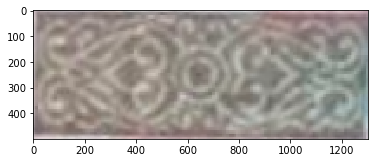

In [40]:
warped2 = four_point_transform(orig, approx.reshape(4, 2) * ratio)
warped2 =imutils.resize(warped2, height = 500)
plt.imshow(warped2)